# Setup and Imports

In [34]:
!pip3 install -r ../requirements.txt

   ---------------------------------------- 0.0/992.0 kB ? eta -:--:--
   --- ------------------------------------ 92.2/992.0 kB ? eta -:--:--
   --- ------------------------------------ 92.2/992.0 kB ? eta -:--:--
   ---- ----------------------------------- 112.6/992.0 kB 1.1 MB/s eta 0:00:01
   ----- -------------------------------- 143.4/992.0 kB 944.1 kB/s eta 0:00:01
   ----- -------------------------------- 143.4/992.0 kB 944.1 kB/s eta 0:00:01
   ------ ------------------------------- 174.1/992.0 kB 551.6 kB/s eta 0:00:02
   ------- ------------------------------ 194.6/992.0 kB 535.8 kB/s eta 0:00:02
   ------- ------------------------------ 204.8/992.0 kB 497.6 kB/s eta 0:00:02
   --------- ---------------------------- 235.5/992.0 kB 424.3 kB/s eta 0:00:02
   --------- ---------------------------- 235.5/992.0 kB 424.3 kB/s eta 0:00:02
   --------- ---------------------------- 256.0/992.0 kB 357.7 kB/s eta 0:00:03
   --------- ---------------------------- 256.0/992.0 kB 357.7 kB


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import re
import os
import matplotlib.pyplot as plt
import numpy as np
from dataset_loader import load_dataset

from transformers import pipeline

# Loading the Data

In [2]:
entries = load_dataset("../data/dataset")
print(f"\nTotal diary entries loaded: {len(entries)}")

  0%|          | 0/100 [00:00<?, ?it/s]


Total diary entries loaded: 926


In [3]:
sentiment_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment")

model.safetensors:  91%|######### | 1.01G/1.11G [00:00<?, ?B/s]

Device set to use cpu


c:\Program Files\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--cardiffnlp--twitter-xlm-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


# Utility Functions

In [11]:
def label_sentiment(text):
    """
    Labels a diary entry as 'Positive', 'Negative', or 'Neutral' using a simple lexicon-based approach.
    
    Args:
        text (str): The diary entry text.
    
    Returns:
        str: Sentiment label.
    """
    # Converting text to lowercase for case-insensitive matching.
    text_lower = text.lower()
    
    # Define keywords (these can be expanded or modified as needed).
    positive_keywords = [
        'acha', 'maza', 'khush', 'happy', 'great', 'mazedaar',
        'fresh', 'alhamdulillah', 'achay', 'enjoy', 'fun', 'excellent'
    ]
    negative_keywords = [
        'thak', 'assignments', 'stress', 'deadline', 'bura', 'exams',
        'rash', 'soogaya', 'tired', 'fail', 'problem', 'dull'
    ]
    
    # Counting occurrences of positive and negative keywords.
    pos_score = sum(word in text_lower for word in positive_keywords)
    neg_score = sum(word in text_lower for word in negative_keywords)
    
    # Returning the sentiment label based on scores.
    if pos_score > neg_score:
        return "positive"
    elif neg_score > pos_score:
        return "negative"
    else:
        return "neutral"

def compute_sentiment_score(label):
    """
    Maps a sentiment label to a numeric score.
    
    Args:
        label (str): Sentiment label ("Positive", "Negative", "Neutral").
    
    Returns:
        int: Score (+1 for Positive, -1 for Negative, 0 for Neutral).
    """
    mapping = {"Positive": 1, "Negative": -1, "Neutral": 0}
    
    return mapping.get(label, 0)

def generate_ground_truth_labels(entries):
    """
    Generates sentiment labels for each diary entry using a pre-trained sentiment analysis model.
    
    Args:
        entries (list of str): List of diary entries.
        
    Returns:
        list of str: Predicted sentiment labels.
    """
    gt_labels = []
    
    # Processing each entry using the pipeline.
    for entry in entries:
        result = sentiment_classifier(entry)
        # The model returns a list of dicts, each containing a label and score.
        # We use the top label as the pseudo ground truth.
        gt_labels.append(result[0]['label'])
    
    return gt_labels


def evaluate_sentiment_performance(predictions, ground_truth):
    """
    Evaluates the performance of the sentiment classification model.
    
    Args:
        predictions (list of str): Predicted sentiment labels.
        ground_truth (list of str): Manually annotated ground truth sentiment labels.
    
    Returns:
        dict: Evaluation metrics including accuracy, precision, recall, f1-score, and confusion matrix.
    """
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

    accuracy = accuracy_score(ground_truth, predictions)
    
    precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predictions, average='weighted')
    
    conf_matrix = confusion_matrix(ground_truth, predictions)
    
    report = classification_report(ground_truth, predictions)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'classification_report': report
    }

# Implementation Based Functions

In [12]:
def perform_sentiment_analysis(entries):
    """
    Processes a list of diary entries to assign a sentiment label to each entry.
    
    Args:
        entries (list of str): Diary entries.
    
    Returns:
        list of str: List of sentiment labels corresponding to each entry.
    """
    sentiments = []
    
    for entry in entries:
        sentiment = label_sentiment(entry)
        sentiments.append(sentiment)
    
    return sentiments

def compute_trends(scores, window_size=7):
    """
    Computes the moving average of sentiment scores to reveal trends over time.
    
    Args:
        scores (list of int): Numeric sentiment scores.
        window_size (int): The size of the window to aggregate sentiment scores (default is 7 for weekly trends).
    
    Returns:
        np.ndarray: Array of moving average scores.
    """
    scores_array = np.array(scores)
    
    if len(scores_array) < window_size:
        # If there are fewer entries than the window size, simply return the original scores.
        return scores_array
    
    # Computing the moving average using convolution.
    window = np.ones(window_size) / window_size
    moving_avg = np.convolve(scores_array, window, mode='valid')
    
    return moving_avg

def plot_sentiment_trends(daily_scores, moving_avg, window_size=7):
    """
    Generates visualizations for sentiment trends over time.
    
    Args:
        daily_scores (list of int): Daily sentiment scores.
        moving_avg (np.ndarray): The computed moving average of sentiment scores.
        window_size (int): The aggregation window size (e.g., 7 for weekly).
    """
    plt.figure(figsize=(12, 6))
    
    # Plotting daily sentiment scores.
    plt.plot(range(1, len(daily_scores)+1), daily_scores, marker='o', linestyle='-', color='lightgray', label='Daily Score')
    
    # Plotting moving average to show trends.
    start_idx = window_size // 2  # approximate alignment for moving average
    plt.plot(range(start_idx+1, start_idx+len(moving_avg)+1), moving_avg, marker='s', linestyle='-', color='blue', label=f'{window_size}-day Moving Average')
    
    plt.xlabel("Time (Diary Entry Index)")
    plt.ylabel("Sentiment Score")
    plt.title("Sentiment Trends Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

def plot_stress_happy_periods(daily_scores, window_size=7, happy_threshold=0.2, stress_threshold=-0.2):
    """
    Plots the moving average sentiment scores and highlights happy and stress periods.
    
    Happy periods are highlighted in green and stress periods in red based on the thresholds.
    
    Args:
        daily_scores (list of int): Daily sentiment scores.
        window_size (int): Window size for the moving average.
        happy_threshold (float): Threshold above which a period is considered happy.
        stress_threshold (float): Threshold below which a period is considered stressful.
    """
    moving_avg = compute_trends(daily_scores, window_size)
    
    # Aligning x-axis indices with the moving average (approximated alignment).
    x = np.arange(window_size // 2, window_size // 2 + len(moving_avg))
    
    plt.figure(figsize=(12, 6))
    plt.plot(x, moving_avg, marker='o', linestyle='-', color='blue', label='Moving Average Sentiment')
    
    # Highlighting periods based on the thresholds.
    for i in range(len(moving_avg)):
        
        if moving_avg[i] >= happy_threshold:
            plt.axvspan(x[i] - 0.5, x[i] + 0.5, color='green', alpha=0.7)
        elif moving_avg[i] <= stress_threshold:
            plt.axvspan(x[i] - 0.5, x[i] + 0.5, color='red', alpha=0.7)
    
    plt.xlabel("Time (Diary Entry Index)")
    plt.ylabel("Sentiment Score (Moving Average)")
    plt.title("Highlighted Happy (Green) and Stress (Red) Periods")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()

# Driver Function

> Sample diary entries:
1. subha 5 bjhey uthna perha trip thaa jaldi jaldi ready hua aur 0540 ghar saay nikal gaay
2. 0615 bus chal perhee joo kaay first time thaa kaay trip time saay chala
3. nust kaay 3 larkay thy unsaay batain kee phir bluetooth trip coordinator kaay pass thaa tou humm shoor daltay rahay kaay song change krr dain
4. phir murree mein nashtay kaay leya uthay phir usskay baad bluetooth humain mil gaya
5. mein tou soogaya phir hum jaga prr phouch gaay udhar 3 peaks theen 2 perr char gaay

> Sentiment labels for the first five diary entries:
1. neutral
2. neutral
3. neutral
4. neutral
5. negative

> Frequency of unique sentiment labels:
>> neutral: 819
>> negative: 39
>> positive: 68

> Evaluating the performance of the sentiment analysis model
Accuracy: 0.4222462203023758
Precision: 0.4694752215556433
Recall: 0.4222462203023758
F1 Score: 0.3190334639363293
Confusion Matrix:
 [[ 15 286  18]
 [ 12 331   5]
 [ 12 202  45]]
Classification Report:
               precision   

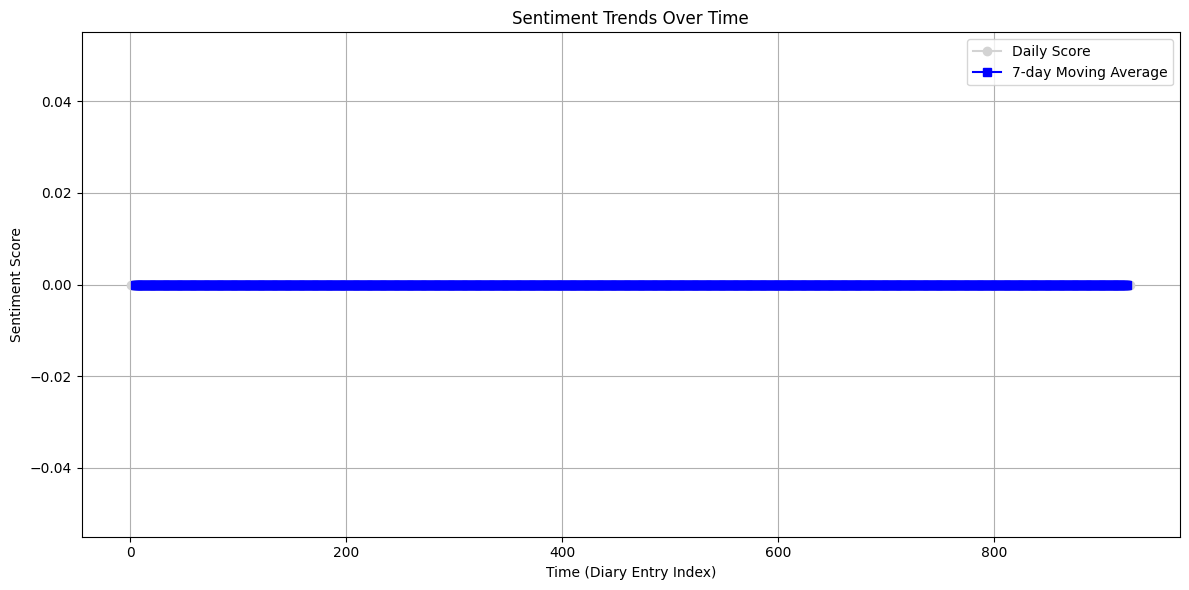

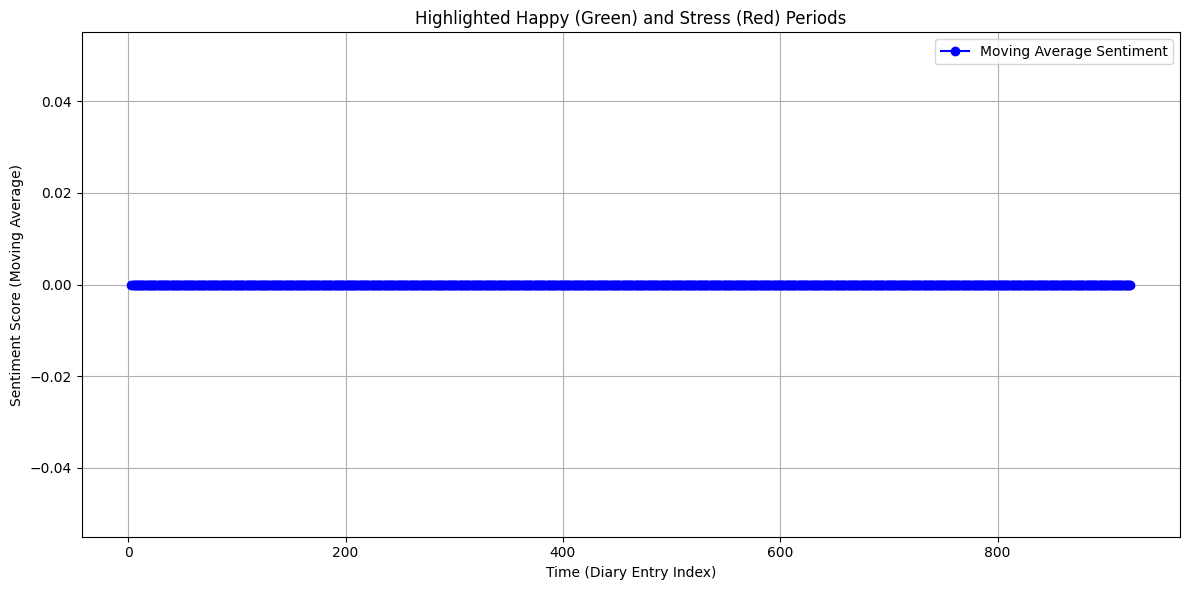

In [13]:
if __name__ == '__main__':
    print("> Sample diary entries:")
    for i, entry in enumerate(entries[:5]):
        print(f"{i+1}. {entry}")

    # Generating ground truth sentiment labels using a pre-trained model
    gt_labels = generate_ground_truth_labels(entries)
    
    # Performing Basic Sentiment Classification.
    sentiments = perform_sentiment_analysis(entries)

    print("\n> Sentiment labels for the first five diary entries:")
    for i, sentiment in enumerate(sentiments[:5]):
        print(f"{i+1}. {sentiment}")

    from collections import Counter

    # Assuming `sentiments` is your list of sentiment labels
    sentiment_counts = Counter(sentiments)

    # Printing the frequency of each unique sentiment
    print("\n> Frequency of unique sentiment labels:")
    for sentiment, count in sentiment_counts.items():
        print(f">> {sentiment}: {count}")

    print("\n> Evaluating the performance of the sentiment analysis model")
    sentiment_performance = evaluate_sentiment_performance(sentiments, gt_labels)
    
    # Computing numeric sentiment scores.
    daily_scores = [compute_sentiment_score(label) for label in sentiments]
    
    # Computing a 7-day moving average to capture weekly sentiment trends.
    window_size = 7
    moving_avg = compute_trends(daily_scores, window_size)
    
    # Visualizing sentiment trends.
    print("\n> Visualizing sentiment trends:")
    plot_sentiment_trends(daily_scores, moving_avg, window_size)
    plot_stress_happy_periods(daily_scores, window_size)

### For, testing

In [14]:
print(gt_labels)
print(sentiments)

['positive', 'neutral', 'negative', 'neutral', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'neutral', 'positive', 'negative', 'positive', 'positive', 'positive', 'neutral', 'neutral', 'negative', 'positive', 'neutral', 'positive', 'negative', 'negative', 'neutral', 'neutral', 'negative', 'positive', 'positive', 'positive', 'positive', 'neutral', 'negative', 'negative', 'negative', 'neutral', 'neutral', 'negative', 'neutral', 'negative', 'positive', 'positive', 'neutral', 'neutral', 'positive', 'positive', 'positive', 'negative', 'neutral', 'neutral', 'negative', 'negative', 'negative', 'positive', 'positive', 'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'neutral', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'neutral', '